In [1]:
import os

# Limit TensorFlow to 1 thread for the physical cores to avoid oversubscription
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [23]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np

from deepxde.backend import tf
import matplotlib.pyplot as plt
D = 3.8e-11 #m^2/s
C0 = 0.0 #moles/m^3
C1 = 100 #moles/m^3
l = 0.05 #m
def pde(x, y):
   
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  
    return (dy_t- D*dy_xx)

def f(x):
    return np.sin(np.pi * x / l)
    
def func(x):
    n_terms = 2  # Number of terms in the series to approximate the solution
    result = C0 + (x[:, 0:1] / l) * (C1 - C0)
    for n in range(1, n_terms + 1):
        from scipy.integrate import quad
        integral, _ = quad(lambda x: f(x) * np.sin(n * np.pi * x/ l), 0, l)
        cn = (2 / l) * integral + (2 / (n * np.pi)) * ((-1)**n * (C1 - C0))  
        term = cn * np.exp(-n**2 * np.pi**2 * D * x[:, 1:2] / l**2) * np.sin(n * np.pi * x[:, 0:1] / l)
        result += term
    return result



geom = dde.geometry.Interval(0, l)
timedomain = dde.geometry.TimeDomain(0, 100)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


observe_x1 = np.vstack((np.linspace(0, 0.05, num=5), np.full((5), 10))).T
observe_y1 = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)
observe_x2 = np.vstack((np.linspace(0, 0.05, num=5), np.full((5), 1))).T
observe_y2 = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)
data = dde.data.TimePDE(geomtime, pde, [observe_y1,observe_y2 ], num_domain=40, solution=func, num_test=10000)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"


net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
losshistory, train_state = model.train(iterations=100000)

Compiling model...
Building feed-forward neural network...
'build' took 0.044832 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.506764 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [7.81e-05, 2.07e+03, 2.07e+03]    [2.18e-04, 2.07e+03, 2.07e+03]    [1.00e+00]    
1000      [2.27e-06, 1.67e+03, 1.67e+03]    [1.08e-01, 1.67e+03, 1.67e+03]    [2.18e+00]    
2000      [2.61e-03, 3.64e+02, 3.64e+02]    [9.65e+01, 3.64e+02, 3.64e+02]    [5.98e+00]    
3000      [6.69e-04, 1.12e+02, 1.12e+02]    [2.26e+02, 1.12e+02, 1.12e+02]    [8.16e+00]    
4000      [3.11e-04, 6.69e+01, 6.69e+01]    [3.23e+02, 6.69e+01, 6.69e+01]    [9.23e+00]    
5000      [2.34e-04, 6.37e+01, 6.37e+01]    [3.71e+02, 6.37e+01, 6.37e+01]    [9.57e+00]    
6000      [1.29e-04, 6.36e+01, 6.36e+01]    [3.88e+02, 6.36e+01, 6.36e+01]    [9.62e+00]    
7000      [2.03e-01, 1.90e+01, 1.90e+01]    [5.31e+02, 1.90e+01, 1.90e+01]    [9.95e+00]    
8000      [4.60e-02, 1.60e+01, 1.60e+01]    [5.59e+02, 1.60e+01, 1.60e+01]    [9.91e+00]    
9000      [1.48e-02, 1.5

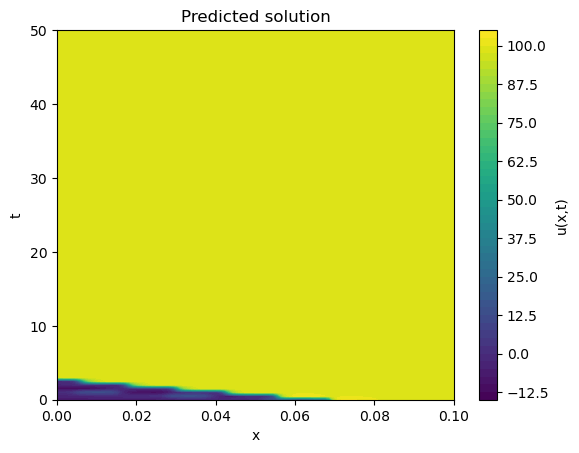

Saving loss history to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\test.dat ...


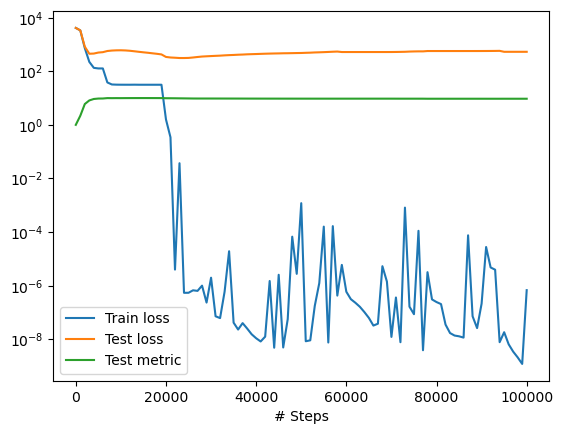

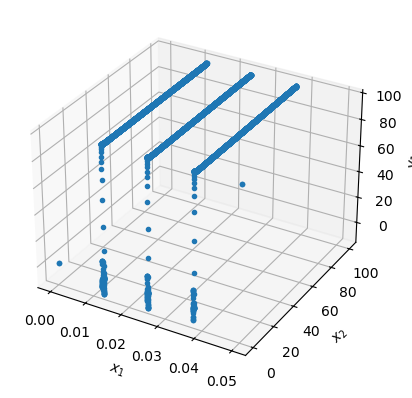

In [31]:
import matplotlib.pyplot as plt

# Create a grid of points to evaluate the solution
x = np.linspace(0, 0.1, 100)
t = np.linspace(0, 50, 100)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution
plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [13]:
# Define points where you want to evaluate the solution
points = np.array([[0.5, 0.5], [0,5, 1]])  # Example points (x, t)

# Use the trained model to predict the solution at these points
y_pred = model.predict(points)
print("Predicted solution at points:", y_pred)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.